In [1]:
## Load libraries
import os
import pandas as pd

# Import shared helpers and TaxSolver components
from case_helpers import (
    tx, DataLoader, BracketInput,
    BudgetConstraint, IncomeConstraint, MarginalPressureConstraint, BracketConstraint,
    BudgetObjective, GurobiBackend,
    load_simple_simul_data, filter_low_income_households,
)

In [2]:
## Load data
file_path = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers = pd.read_excel(file_path)
df_taxpayers['tax'] = df_taxpayers['income_before_tax'] - df_taxpayers['outcome_3']

## Case 2: Complex Tax Rules (outcome_3)

#### Case 2: Recover

In [ ]:
dl = DataLoader(path=df_taxpayers, income_before_tax="income_before_tax", income_after_tax="outcome_3")

# Initialize the model
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),
)

# Define inflection points for general bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 200_000]

# Add split variables for general income brackets (for everybody)
BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Add split variables for single-specific brackets on household income
BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="household_income_before_tax",
    inflection_points=[30_000, 40_000],
    group_vars=["k_single"],
)

# Add split variables for couple-specific brackets on household income
BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="household_income_before_tax",
    inflection_points=[60_000, 75_000],
    group_vars=["k_couple"],
)

# Add split variables for ZZP-specific brackets on income
BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=[0, 15_000],
    group_vars=["k_zzp"],
)

# Define rules
# 1. General progressive income tax brackets
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

# 2. Single-specific brackets for healthcare deductible
single_bracket = tx.BracketRule(
    name="household_income_before_tax_k_single",
    var_name="household_income_before_tax",
    k_group_var="k_single",
    ub=0.8,
    lb=-0.5,
)

# 3. Couple-specific brackets for healthcare deductible
couple_bracket = tx.BracketRule(
    name="household_income_before_tax_k_couple",
    var_name="household_income_before_tax",
    k_group_var="k_couple",
    ub=0.8,
    lb=-0.5,
)

# 4. ZZP-specific brackets for tax credit
zzp_bracket = tx.BracketRule(
    name="income_before_tax_k_zzp",
    var_name="income_before_tax",
    k_group_var="k_zzp",
    ub=0.8,
    lb=-0.5,
)

# 5. Benefits
children_benefit = tx.BenefitRule(
    name="benefit_children",
    var_name="i_children",
)

couple_benefit = tx.BenefitRule(
    name="benefit_couple",
    var_name="k_couple",
)

single_benefit = tx.BenefitRule(
    name="benefit_single",
    var_name="k_single",
)

tax_solver.add_rules([
    income_tax, 
    single_bracket, 
    couple_bracket, 
    zzp_bracket,
    children_benefit,
    couple_benefit,
    single_benefit
])

# Add constraints
income_constraint = IncomeConstraint(0.00000001, dl.households.values()) ## Tight constraints for recovery

# Budget constraint
budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 100_000_000_000 ## Loose to illustrate tight constraints are leading
)

# Marginal pressure constraint (max_marginal_pressure=1)
marginal_pressure_constraint = MarginalPressureConstraint(1.0)

# Note: MarginalPressureConstraint performs best with backend="gurobi"
tax_solver.add_constraints([
    income_constraint, 
    budget_constraint, 
    marginal_pressure_constraint
])

# Add objective
objective = BudgetObjective(budget_constraint)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
pd.set_option('display.float_format', '{:.6f}'.format)
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Directly loading from pd.DataFrame...
Setting 'weight' to 1 as default.
Mirror household were missing for 669 households: set to own id
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Current tax balance All_households: -18038295
New Maximum: 99981961705
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3673 rows, 1025 columns and 6851 nonzeros
Model fingerprint: 0x209ee98c
Model has 12 simple general constraints
  1 MAX, 11 INDICATOR
Variable types: 1014 continuous, 11 integer (11 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 1e+00]
  RHS range        [1e+00, 1e+11]
  GenCon coe range [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid 

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.100005,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.199992,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.300004,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.399995,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_200000,0.500000,1,1
5,household_income_before_tax_k_single__househol...,FlatTaxRule,household_income_before_tax_k_single_30000_40000,0.150012,1,1
6,household_income_before_tax_k_couple__househol...,FlatTaxRule,household_income_before_tax_k_couple_60000_75000,0.075024,1,1
7,income_before_tax_k_zzp__income_before_tax_k_z...,FlatTaxRule,income_before_tax_k_zzp_0_15000,-0.099997,1,1
8,benefit_children,BenefitRule,i_children,799.974859,1,1
9,benefit_couple,BenefitRule,k_couple,1125.811295,1,1


#### Case 2: Reform

In [ ]:
# Initialize the model for reform
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),
)

# Define inflection points for general bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 200_000]

# Add split variables for general income brackets
BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules
# General bracket rule
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

# Child benefit rule
children_benefit = tx.BenefitRule(
    name="benefit_children",
    var_name="i_children",
)

# Universal benefit rule
universal_benefit = tx.BenefitRule(
    name="benefit_everybody",
    var_name="k_everybody",
)

tax_solver.add_rules([income_tax, children_benefit, universal_benefit])

# Add constraints
income_constraint = IncomeConstraint(0.10, dl.households.values()) # All households: 10% max income loss

# Household group <85k must gain at least 5% increase in net income
low_income_households = [
    hh for hh in dl.households.values() 
    if hh.members[0]["household_income_before_tax"] < 85_000
]
income_constraint_low_income = IncomeConstraint(-0.05, low_income_households)

# Budget constraint (non binding)
budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 10_000_000_000
)

# Marginal pressure constraint (max_marginal_pressure=0.6)
marginal_pressure_constraint = MarginalPressureConstraint(0.6)

tax_solver.add_constraints([
    income_constraint, 
    income_constraint_low_income,
    budget_constraint, 
    marginal_pressure_constraint
])

# Create BracketConstraint for ascending rates
bracket_constraint = BracketConstraint(
    rule_family="income_before_tax_k_everybody",
    max_brackets=None,
    ascending=True,
    start_from_first_inflection=False,
    last_bracket_zero=False,
)
bracket_constraint.brackets = income_tax.flat_rules
tax_solver.add_constraints([bracket_constraint])

# Add objective
objective = BudgetObjective(budget_constraint)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
pd.set_option('display.float_format', '{:.6f}'.format)
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Current tax balance All_households: -18038295
New Maximum: 9981961705
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3893 rows, 1017 columns and 6705 nonzeros
Model fingerprint: 0xc9802597
Model has 8 simple general constraints
  1 MAX, 7 INDICATOR
Variable types: 1010 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 1e+10]
  GenCon coe range [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3220 rows and 1010 columns
Presolve time: 0.00s
Presolved: 673 rows, 7 columns, 3818 nonzeros
Variable types: 7 continuous, 0 integer (0 binary)

Root relaxation: objective 1.961929e+06, 17 iterati

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.051927,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.206821,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.206821,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.600000,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_200000,0.600000,1,1
5,benefit_children,BenefitRule,i_children,713.250000,1,1
6,benefit_everybody,BenefitRule,k_everybody,3479.745578,1,1


## Visualization: Tax System Plots

In [ ]:
# Helper functions and configuration for plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Import shared plotting helpers
from case_helpers import euro_format, euro_format_full, wrangle_intervals, build_tax_line

# Configuration - aligned with other case plots
Y_TITLE = "Taxes paid (€)"
X_TITLE = "Income before tax (€)"
TICK_FONT_SIZE = 14

# Use RdYlBu colormap colors (blue for current, red for reform)
cmap = plt.cm.RdYlBu
COLOR_CURRENT = cmap(0.85)  # Current system (blue)
COLOR_REFORM = '#8B0000'   # TaxSolver reform (darkred)
COLOR_ZZP = '#FFB90F'      # Self-employed (yellow)
COLOR_FISCAL_PARTNERS = '#FFB90F'  # Fiscal partners (yellow)

# Load taxpayer data (use first 100 for simple visualization)
file_path_plot = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers_plot = pd.read_excel(file_path_plot)
df_taxpayers_plot = df_taxpayers_plot.iloc[0:100, :].copy()
df_taxpayers_plot["tax_3"] = df_taxpayers_plot["income_before_tax"] - df_taxpayers_plot["outcome_3"]

Loaded 100 taxpayers for visualization


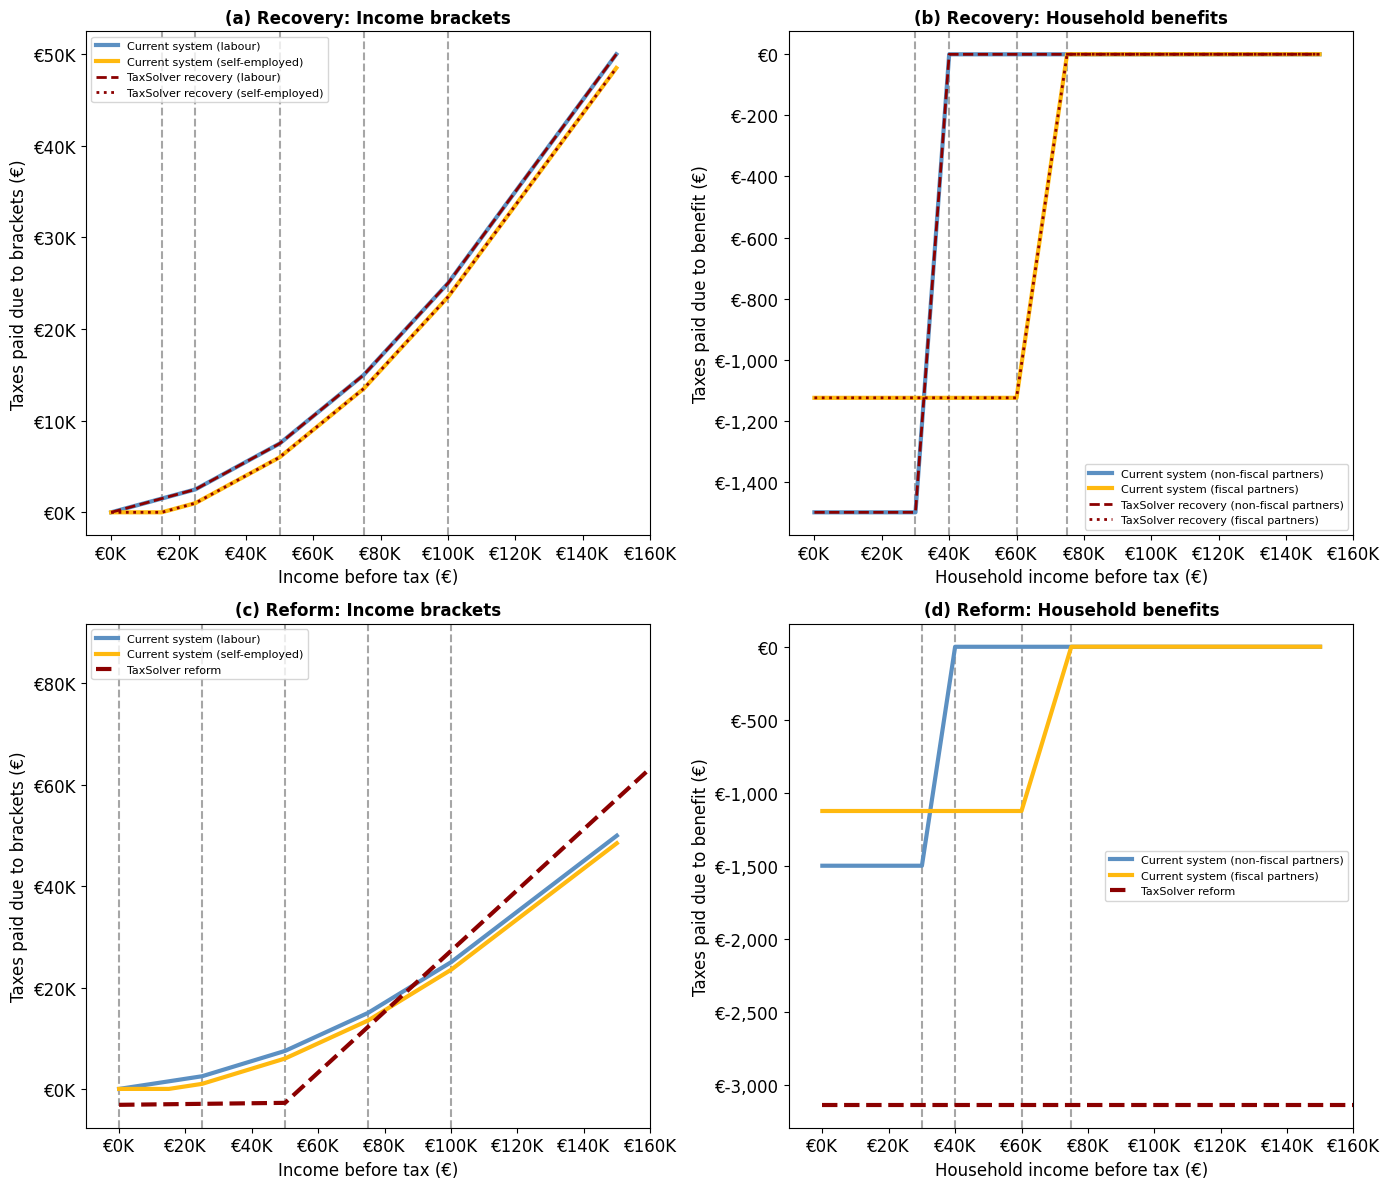

Combined figure saved to ./output/case_2_combined.png


In [ ]:
# COMBINED 2x2 FIGURE: Recovery (top) + Reform (bottom)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Load interval data for recovery
df_intervals_recover = pd.read_excel("./systems_old/case_3_recover_inc_0.xlsx")

# Filter for income-based brackets (labour)
df_intervals_income = wrangle_intervals(df_intervals_recover, df_taxpayers_plot, filter_var="income_before_tax")
x_income, y_income, current_y_income = build_tax_line(df_intervals_income, start_y=0)

# Load ZZP-specific intervals (self-employed)
df_intervals_zzp = pd.read_excel("./systems_old/case_3_recover_zzp.xlsx")
df_intervals_zzp = wrangle_intervals(df_intervals_zzp, df_taxpayers_plot)
x_zzp, y_zzp, _ = build_tax_line(df_intervals_zzp, start_y=0)

# Filter for household income brackets (singles/non-fiscal partners)
df_intervals_singles = wrangle_intervals(df_intervals_recover, df_taxpayers_plot, 
                                          filter_rule="progressive_household_income_before_tax_k_single")
BENEFIT_SINGLES = 1_500  # Healthcare benefit for non-fiscal partners
x_singles, y_singles, current_y_singles = build_tax_line(df_intervals_singles, start_y=-BENEFIT_SINGLES)

# Filter for household income brackets (couples/fiscal partners)
df_intervals_couples = wrangle_intervals(df_intervals_recover, df_taxpayers_plot,
                                          filter_rule="progressive_household_income_before_tax_k_couple")
BENEFIT_COUPLES = 1_125  # Healthcare benefit for fiscal partners
x_couples, y_couples, current_y_couples = build_tax_line(df_intervals_couples, start_y=-BENEFIT_COUPLES)

# Load reform data
df_intervals_reform = pd.read_excel("./systems_old/case_3_reform_1.xlsx")
df_intervals_reform = wrangle_intervals(df_intervals_reform, df_taxpayers_plot)
BENEFIT_REFORM = 3_138  # Universal benefit from reform
x_reform, y_reform, current_y_reform = build_tax_line(df_intervals_reform, start_y=-BENEFIT_REFORM)

# ========== TOP LEFT: Recovery - Income Brackets ==========
ax1 = axes[0, 0]

# Add vertical lines for bracket boundaries
for income in [15_000, 25_000, 50_000, 75_000, 100_000]:
    ax1.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot current system (labour and self-employed)
ax1.plot(x_income, y_income, label="Current system (labour)", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax1.plot(x_zzp, y_zzp, label="Current system (self-employed)", color=COLOR_ZZP, linestyle="-", linewidth=3)

# Plot TaxSolver recovery (same rates recovered)
ax1.plot(x_income, y_income, label="TaxSolver recovery (labour)", color=COLOR_REFORM, linestyle="--", linewidth=2)
ax1.plot(x_zzp, y_zzp, label="TaxSolver recovery (self-employed)", color=COLOR_REFORM, linestyle=":", linewidth=2)

ax1.set_xlabel(X_TITLE, fontsize=12)
ax1.set_ylabel("Taxes paid due to brackets (€)", fontsize=12)
ax1.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax1.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim(right=160_000)
ax1.legend(fontsize=8, loc='upper left')
ax1.set_title("(a) Recovery: Income brackets", fontsize=12, fontweight='bold')

# ========== TOP RIGHT: Recovery - Household Benefits ==========
ax2 = axes[0, 1]

# Add vertical lines for bracket boundaries
for income in [30_000, 40_000, 60_000, 75_000]:
    ax2.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot current system (non-fiscal partners and fiscal partners)
ax2.plot(x_singles, y_singles, label="Current system (non-fiscal partners)", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax2.plot(x_couples, y_couples, label="Current system (fiscal partners)", color=COLOR_FISCAL_PARTNERS, linestyle="-", linewidth=3)

# Plot TaxSolver recovery
ax2.plot(x_singles, y_singles, label="TaxSolver recovery (non-fiscal partners)", color=COLOR_REFORM, linestyle="--", linewidth=2)
ax2.plot(x_couples, y_couples, label="TaxSolver recovery (fiscal partners)", color=COLOR_REFORM, linestyle=":", linewidth=2)

ax2.set_xlabel("Household income before tax (€)", fontsize=12)
ax2.set_ylabel("Taxes paid due to benefit (€)", fontsize=12)
ax2.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax2.yaxis.set_major_formatter(FuncFormatter(euro_format_full))
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlim(right=160_000)
ax2.legend(fontsize=8, loc='lower right')
ax2.set_title("(b) Recovery: Household benefits", fontsize=12, fontweight='bold')

# ========== BOTTOM LEFT: Reform - Income Brackets ==========
ax3 = axes[1, 0]

# Add vertical lines for bracket boundaries
for income in [0, 25_000, 50_000, 75_000, 100_000]:
    ax3.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot current system
ax3.plot(x_income, y_income, label="Current system (labour)", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax3.plot(x_zzp, y_zzp, label="Current system (self-employed)", color=COLOR_ZZP, linestyle="-", linewidth=3)

# Plot TaxSolver reform
ax3.plot(x_reform, y_reform, label="TaxSolver reform", color=COLOR_REFORM, linestyle="--", linewidth=3)

# Add rate text boxes for reform
for i, row in df_intervals_reform.iterrows():
    x_mid = (row["bracket_start"] + row["bracket_end"]) / 2
    y_mid = current_y_reform / 2 + (4000 if i in [1, 3] else 0)
    rate_text = f"{row['rate']:.0%}"
    ax3.text(x_mid, y_mid, rate_text, fontsize=9, color="black",
             ha="center", va="center",
             bbox=dict(facecolor="white", edgecolor=COLOR_REFORM, linestyle="-", linewidth=1.5, boxstyle="round,pad=0.3"))

ax3.set_xlabel(X_TITLE, fontsize=12)
ax3.set_ylabel("Taxes paid due to brackets (€)", fontsize=12)
ax3.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax3.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax3.tick_params(axis='both', labelsize=12)
ax3.set_xlim(right=160_000)
ax3.legend(fontsize=8, loc='upper left')
ax3.set_title("(c) Reform: Income brackets", fontsize=12, fontweight='bold')

# ========== BOTTOM RIGHT: Reform - Household Benefits ==========
ax4 = axes[1, 1]

# Add vertical lines for bracket boundaries
for income in [30_000, 40_000, 60_000, 75_000]:
    ax4.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot current system
ax4.plot(x_singles, y_singles, label="Current system (non-fiscal partners)", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax4.plot(x_couples, y_couples, label="Current system (fiscal partners)", color=COLOR_FISCAL_PARTNERS, linestyle="-", linewidth=3)

# Plot TaxSolver reform - flat universal benefit
ax4.plot([0, 200_000], [-BENEFIT_REFORM, -BENEFIT_REFORM], label="TaxSolver reform", 
          color=COLOR_REFORM, linestyle="--", linewidth=3)

ax4.set_xlabel("Household income before tax (€)", fontsize=12)
ax4.set_ylabel("Taxes paid due to benefit (€)", fontsize=12)
ax4.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax4.yaxis.set_major_formatter(FuncFormatter(euro_format_full))
ax4.tick_params(axis='both', labelsize=12)
ax4.set_xlim(right=160_000)
ax4.legend(fontsize=8, loc='center right')
ax4.set_title("(d) Reform: Household benefits", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
